In [2]:
import pandas as pd
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PolynomialFeatures
import sklearn.metrics as metrics
import sklearn.utils as utils
import os

In [64]:
files = os.listdir('../Data/rmsds')
first = True
data = pd.read_csv("../Data/rmsds/5HT2B_rmsds.csv")

for file in files:
    if file[-4:] == '.csv' and file != '5HT2B_rmsds.csv':
        fileData = pd.read_csv("../Data/rmsds/" + file)
        data = pd.concat([data, fileData], sort=False)
data = data[data['secondary structure'] != -1]
prots = data['protein'].unique()

utils.shuffle(prots, random_state=7)

train_prots = prots[:len(prots) * 66 // 100]
test_prots = prots[len(prots) * 66 // 100:]

train_data = data[data['protein'].isin(train_prots)]
test_data = data[data['protein'].isin(test_prots)]
MAPK14_2YIX_3D83_data = data[(data['protein'] == 'MAPK14') & (data['start ligand'] == '2YIX') & (data['target ligand'] == '3D83')]

X_train = train_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'rmsd', 'normal variate bfactor', 'res name'],
                          axis=1).values
Y_train = train_data['rmsd'].values > 2

X_test = test_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'rmsd', 'normal variate bfactor', 'res name'],
                        axis=1).values
Y_test = test_data['rmsd'].values > 2

MAPK14_2YIX_3D83_X_test = MAPK14_2YIX_3D83_data.drop(['protein', 'start ligand', 'target ligand', 'name', 'num', 'rmsd', 'normal variate bfactor', 'res name'],
                          axis=1).values
MAPK14_2YIX_3D83_Y_test = MAPK14_2YIX_3D83_data['rmsd'].values > 2

X_true = X_train[Y_train == True]
Y_true = Y_train[Y_train == True]

In [65]:
X_train_expanded_50 = np.append(X_train, X_true, axis=0)
Y_train_expanded_50 = np.append(Y_train, Y_true, axis=0)

for i in range(4):
    X_train_expanded_50 = np.append(X_train_expanded_50, X_true, axis=0)
    Y_train_expanded_50 = np.append(Y_train_expanded_50, Y_true, axis=0)
    
print('Ratio of positive examples (50)', np.sum(Y_train_expanded_50)/len(Y_train_expanded_50))

Ratio of positive examples (50) 0.4705209822008575


In [13]:
dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    #     "Nearest Neighbors": KNeighborsClassifier(),
    #     "Linear SVM": SVC(),
    #     "Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=1000),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Decision Tree with max depth = 03": tree.DecisionTreeClassifier(max_depth=3),
    "Decision Tree with max depth = 05": tree.DecisionTreeClassifier(max_depth=5),
    "Decision Tree with max depth = 10": tree.DecisionTreeClassifier(max_depth=10),
    "Decision Tree with max depth = 15": tree.DecisionTreeClassifier(max_depth=15),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    #     "Neural Net": MLPClassifier(alpha = 1),
    "Naive Bayes": GaussianNB(),
    # "AdaBoost": AdaBoostClassifier(),
    # "QDA": QuadraticDiscriminantAnalysis(),
    # "Gaussian Process": GaussianProcessClassifier()
}

In [14]:
def batch_classify(X_train, Y_train, X_test, Y_test, verbose=True, include_y_pred=False):
    """
    This method, takes as input the X, Y matrices of the Train and Test set.
    And fits them on all of the Classifiers specified in the dict_classifier.
    The trained models, and accuracies are saved in a dictionary. The reason to use a dictionary
    is because it is very easy to save the whole dictionary with the pickle module.

    Usually, the SVM, Random Forest and Gradient Boosting Classifier take quiet some time to train.
    So it is best to train them on a smaller dataset first and
    decide whether you want to comment them out or not based on the test accuracy score.
    """

    dict_models = {}
    for classifier_name, classifier in list(dict_classifiers.items()):
        t_start = time.process_time()
        classifier.fit(X_train, Y_train)
        t_end = time.process_time()

        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        Y_pred = classifier.predict(X_test)
        test_score = classifier.score(X_test, Y_test)
        recall = metrics.recall_score(Y_test, Y_pred)
        precision = metrics.precision_score(Y_test, Y_pred)

        if include_y_pred:
            dict_models[classifier_name] = {'model': classifier_name, 'train_score': train_score,
                                            'test_score': test_score, 'recall_score': recall,
                                            'precision_score': precision, 'train_time': t_diff, 'y_pred': Y_pred}
        else:
            dict_models[classifier_name] = {'model': classifier_name, 'train_score': train_score,
                                            'test_score': test_score, 'recall_score': recall,
                                            'precision_score': precision, 'train_time': t_diff}
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=classifier_name, f=t_diff))
    return dict_models

In [67]:
dict_models = batch_classify(X_train_expanded_50, Y_train_expanded_50, X_test, Y_test)
pd.DataFrame.from_dict(dict_models, orient='index')

/Users/sbalachandar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


trained Logistic Regression in 1.95 s
trained Decision Tree in 4.19 s
trained Decision Tree with max depth = 03 in 2.52 s
trained Decision Tree with max depth = 05 in 2.78 s
trained Decision Tree with max depth = 10 in 3.21 s
trained Decision Tree with max depth = 15 in 3.42 s
trained Random Forest in 249.24 s
trained Naive Bayes in 0.77 s


,model,train_score,test_score,recall_score,precision_score,train_time
Decision Tree,Decision Tree,0.951595,0.776950,0.349801,0.275471,4.185362
Decision Tree with max depth = 03,Decision Tree with max depth = 03,0.677553,0.665981,0.562398,0.227120,2.521170
Decision Tree with max depth = 05,Decision Tree with max depth = 05,0.719589,0.663768,0.679737,0.249309,2.783360
Decision Tree with max depth = 10,Decision Tree with max depth = 10,0.806756,0.686415,0.584626,0.245969,3.207466
Decision Tree with max depth = 15,Decision Tree with max depth = 15,0.892731,0.736733,0.447792,0.256038,3.424916
Logistic Regression,Logistic Regression,0.682760,0.694471,0.614237,0.258155,1.949720
Naive Bayes,Naive Bayes,0.668601,0.735947,0.529390,0.276060,0.770962
Random Forest,Random Forest,0.951595,0.841041,0.297667,0.416684,249.239886


In [66]:
MAPK14_2YIX_3D83_dict_models = batch_classify(X_train_expanded_50, Y_train_expanded_50, MAPK14_2YIX_3D83_X_test, MAPK14_2YIX_3D83_Y_test, include_y_pred=True)

/Users/sbalachandar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


trained Logistic Regression in 2.05 s
trained Decision Tree in 4.33 s
trained Decision Tree with max depth = 03 in 2.53 s
trained Decision Tree with max depth = 05 in 2.80 s
trained Decision Tree with max depth = 10 in 3.22 s
trained Decision Tree with max depth = 15 in 3.49 s
trained Random Forest in 250.11 s
trained Naive Bayes in 1.22 s


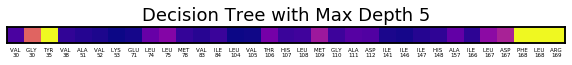

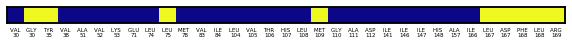

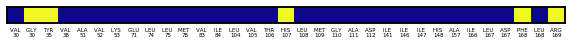

In [60]:
selected = MAPK14_2YIX_3D83_data.loc[(MAPK14_2YIX_3D83_data['start ligand'] == '2YIX') & (MAPK14_2YIX_3D83_data['target ligand'] == '3D83')]
rmsd = np.array(selected['rmsd'])
rmsd[rmsd > 8] = 8
rmsd_formatted = np.expand_dims(rmsd, axis=0)
sns.set_context("talk", font_scale=1.0)

plt.imshow(rmsd_formatted, cmap="plasma", interpolation='none')

fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

#plt.colorbar()
plt.title('Decision Tree with Max Depth 5')
plt.show()

bin_rmsd_formatted = np.expand_dims(MAPK14_2YIX_3D83_Y_test, axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

#plt.colorbar()
plt.show()

bin_pred_rmsd_formatted = np.expand_dims(MAPK14_2YIX_3D83_dict_models['Decision Tree with max depth = 05']['y_pred'], axis=0)
sns.set_context("talk", font_scale=1.0)
plt.imshow(bin_pred_rmsd_formatted, cmap="plasma", interpolation='none')
fig = plt.gcf()
fig.set_size_inches(10,3)

ax = plt.gca()
labels = [r+'\n'+str(i) for r,i in zip(selected['name'], selected['num'])]
plt.xticks(np.arange(0,len(selected)),labels)
plt.yticks([],[])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.tick_params(axis='both', labelsize=5.5)

#plt.colorbar()
plt.show()

In [62]:
print(train_prots)
print(test_prots)

['5HT2B' 'PLK1' 'SMO' 'NR3C2' 'B2AR' 'CDK2' 'BACE1' 'F2' 'B1AR' 'VDR'
 'CHRM3' 'PDE10A' 'PLAU' 'BRD4' 'ERA' 'AR' 'HSP90AA1' 'SLC6A4' 'GLUT1'
 'BRAF' 'JAK2' 'F11' 'DHFR']
['MAPK14' 'PYGM' 'NR3C1' 'CHK1' 'MGLUR5' 'DAT' 'SIGMAR1' 'PTPN1' 'F10'
 'MEK1' 'ELANE' 'P00760']


In [68]:
dot_data = tree.export_graphviz(dict_classifiers['Decision Tree with Max Depth = 03'], out_file=None, feature_names=data.columns[5:13], filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)
graph

KeyError: 'Decision Tree with Max Depth = 03'

In [69]:
data

,protein,start ligand,target ligand,name,num,bfactor,normalized bfactor,prev bfactor,next bfactor,mol weight,solvent accessibility,secondary structure,ligand similarity,rmsd,normal variate bfactor,res name
0,5HT2B,4IB4,5TVN,TRP,131,52.945714,-0.932384,-0.750709,-0.953941,186.21515,19.665082,1,20,0.368520,NaN,NaN
1,5HT2B,4IB4,5TVN,LEU,132,52.298750,-0.953941,-0.932384,-0.851453,113.16067,0.689631,1,20,0.330603,NaN,NaN
2,5HT2B,4IB4,5TVN,ASP,135,52.543750,-0.945777,-0.943528,-1.085850,114.08138,0.443392,1,20,0.856963,NaN,NaN
3,5HT2B,4IB4,5TVN,VAL,136,48.340000,-1.085850,-0.945777,-1.076603,99.13358,0.119069,1,20,0.155572,NaN,NaN
4,5HT2B,4IB4,5TVN,SER,139,46.298333,-1.153880,-1.007546,-1.276112,87.07880,0.050330,1,20,0.190161,NaN,NaN
5,5HT2B,4IB4,5TVN,THR,140,42.630000,-1.276112,-1.153880,-1.272713,101.10589,0.000000,1,20,0.175922,NaN,NaN
6,5HT2B,4IB4,5TVN,ILE,143,45.687500,-1.174233,-1.140052,-1.177839,113.16067,0.000000,1,20,0.178300,NaN,NaN
7,5HT2B,4IB4,5TVN,ILE,186,46.111250,-1.160114,-1.118671,-1.110041,113.16067,0.992436,1,20,0.112512,NaN,NaN
8,5HT2B,4IB4,5TVN,CYS,207,69.175000,-0.391611,0.142641,-0.678431,102.13543,12.702707,0,20,0.619589,NaN,NaN
9,5HT2B,4IB4,5TVN,VAL,208,60.567143,-0.678431,-0.391611,-0.862475,99.13358,43.425937,0,20,0.702544,NaN,NaN
